In [1]:
import torch
from torch import optim
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as tt

from utils import CustomDataSet, load_data, print_config, DeviceDataLoader, supervised_samples, calc_mean_std, plotting, get_PATH, set_random_seed
import config

from Classify import Classifier

In [2]:
print_config()

RANDOM_SEED   :  11042004
DATA_DIR      :    ./data
USED_DATA     :   CIFAR10
NUM_LABELLED  :      1000
DEVICE        :    cuda:0
EPOCHS        :        10
BATCH_SIZE    :        32
LEARNING_RATE :    0.0004
SCHED         :     False
GAN_BATCH_SIZE:       128


In [3]:
set_random_seed(config.RANDOM_SEED)

Setting seeds ...... 



In [4]:
name = "CNN"

In [5]:
PATH = get_PATH(name)
PATH

'CIFAR10/CNN/_1000'

In [6]:
if config.USED_DATA == "CIFAR10":
	mean = [0.5]*3
	std = [0.5]*3
	train_tfm = tt.Compose([
		tt.RandomCrop(32, padding=4, padding_mode='edge'),
		tt.RandomHorizontalFlip(),
		tt.Normalize(mean, std, inplace=True)
	])

if config.USED_DATA == "MNIST":
	mean = [0.5]
	std = [0.5]
	train_tfm = tt.Compose([
		tt.Normalize(mean, std, inplace=True)
	])

test_tfm = tt.Compose([
	tt.Normalize(mean, std)
])

In [7]:
train_ds, test_ds, classes = load_data(train_tfm, test_tfm)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
n_classes = len(classes)
channels = train_ds.x.shape[1]
n_classes, channels

(10, 3)

In [10]:
X_sup, y_sup = supervised_samples(train_ds.x, train_ds.y, config.NUM_LABELLED, n_classes)

In [11]:
sup_ds = CustomDataSet(X_sup, y_sup, train_tfm)

In [12]:
train_dl = DataLoader(sup_ds, config.BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(test_ds, config.BATCH_SIZE, num_workers=3, pin_memory=True)

In [13]:
train_dl = DeviceDataLoader(train_dl, config.DEVICE)
valid_dl = DeviceDataLoader(valid_dl, config.DEVICE)

In [14]:
test_ds.x.shape, test_ds.y.shape

(torch.Size([10000, 3, 32, 32]), torch.Size([10000]))

In [15]:
model = Classifier(channels, n_classes).to(config.DEVICE, non_blocking=True)
model

Classifier(
  (conv): ConvModel(
    (initial): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (Conv): Sequential(
      (0): ConvBn(
        (Conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): ConvBn(
        (Conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): ConvBn(
        (Conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Bn): BatchNorm2d(512, eps=1e-05

In [16]:
history = model.fit(config.EPOCHS, config.LEARNING_RATE, train_dl, valid_dl, weight_decay=0, grad_clip=None, opt_func=optim.Adam, threshold=0.9925, sched=config.SCHED, PATH=PATH+".pt", save_best=True)

In [18]:
model.load_state_dict(torch.load(PATH+".pt"))

OrderedDict([('conv.conv1.Conv.weight',
              tensor([[[[ 0.1744,  0.1827, -0.0139],
                        [ 0.2366, -0.0250, -0.0944],
                        [ 0.0978,  0.1619,  0.0435]],
              
                       [[-0.1393, -0.1425, -0.1154],
                        [ 0.0114,  0.0696, -0.1024],
                        [-0.1226,  0.0136,  0.1432]],
              
                       [[ 0.1352, -0.3194, -0.3152],
                        [ 0.3103,  0.0069,  0.0008],
                        [ 0.1100,  0.1694,  0.0368]]],
              
              
                      [[[ 0.2510,  0.0366, -0.0544],
                        [ 0.0415,  0.1090,  0.0658],
                        [-0.3043,  0.1160,  0.1766]],
              
                       [[ 0.2454, -0.2210, -0.2750],
                        [-0.1156, -0.0737,  0.0274],
                        [ 0.0131,  0.1884, -0.0883]],
              
                       [[ 0.2364, -0.0128, -0.0109],
                

In [19]:
model.evaluate(valid_dl)

0.10000000149011612

In [20]:
import pickle

In [21]:
with open(PATH + ".pickle", 'wb') as f:
	pickle.dump(history, f)

NameError: name 'history' is not defined

In [ ]:
with open(PATH + ".pickle", 'rb') as f:
	history = pickle.load(f)

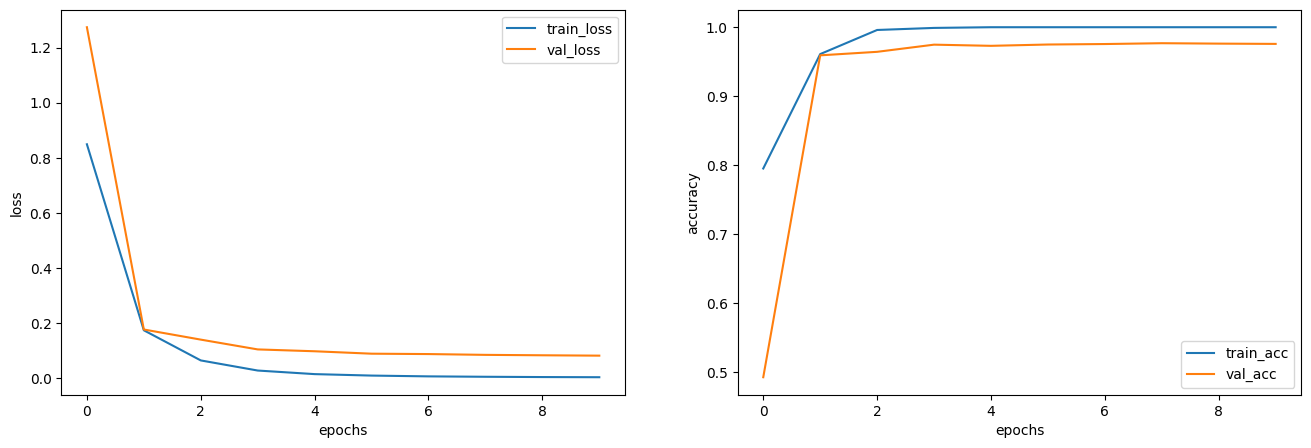

In [ ]:
plotting(history, False)